Dataset loaded with shape: (3000, 24)
        country    city   latitude   longitude  population  year  month  \
0     Indonesia  City_0  -7.564383   62.173078     1742949  2019     12   
1        Brazil  City_1  73.100003  106.805303        7276  2016      4   
2         India  City_2  42.479152  -89.831556    23012977  2015      5   
3       Germany  City_3  23.812188   44.954676     1163003  2023      8   
4  South Africa  City_4 -38.157390   25.828554        6109  2016      1   

   gdp_per_capita  healthcare_index  urbanization_rate  ...   humidity  \
0    14389.016790         69.921570          75.005333  ...  61.129302   
1     5052.020649         57.540539          66.128303  ...  25.818590   
2     3859.306481         80.756688          62.298967  ...  42.313117   
3    10215.108237         95.353533          76.343555  ...  47.400726   
4     1605.121968         47.632519          66.131046  ...  34.748396   

        pm25        pm10        no2        so2         o3        c

/tmp/ipython-input-2965947238.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


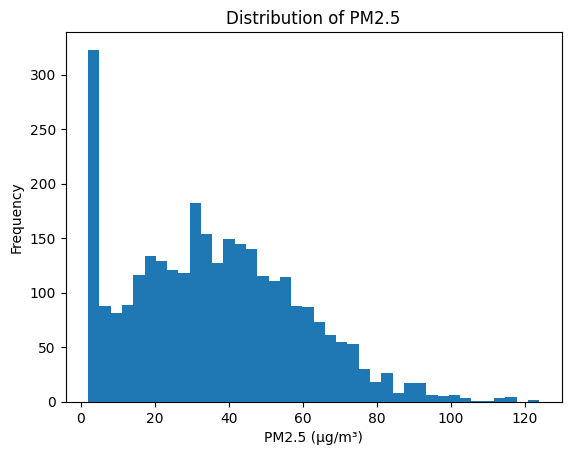

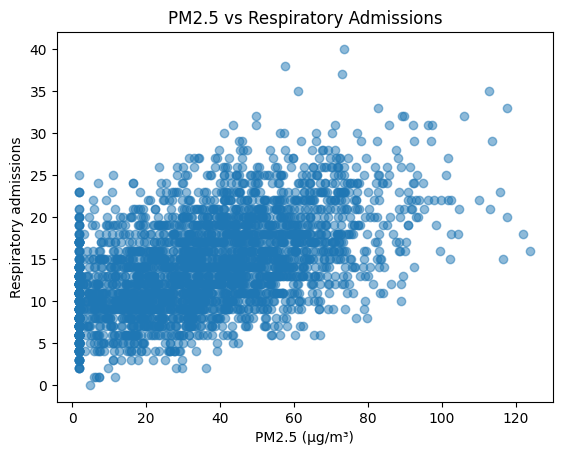

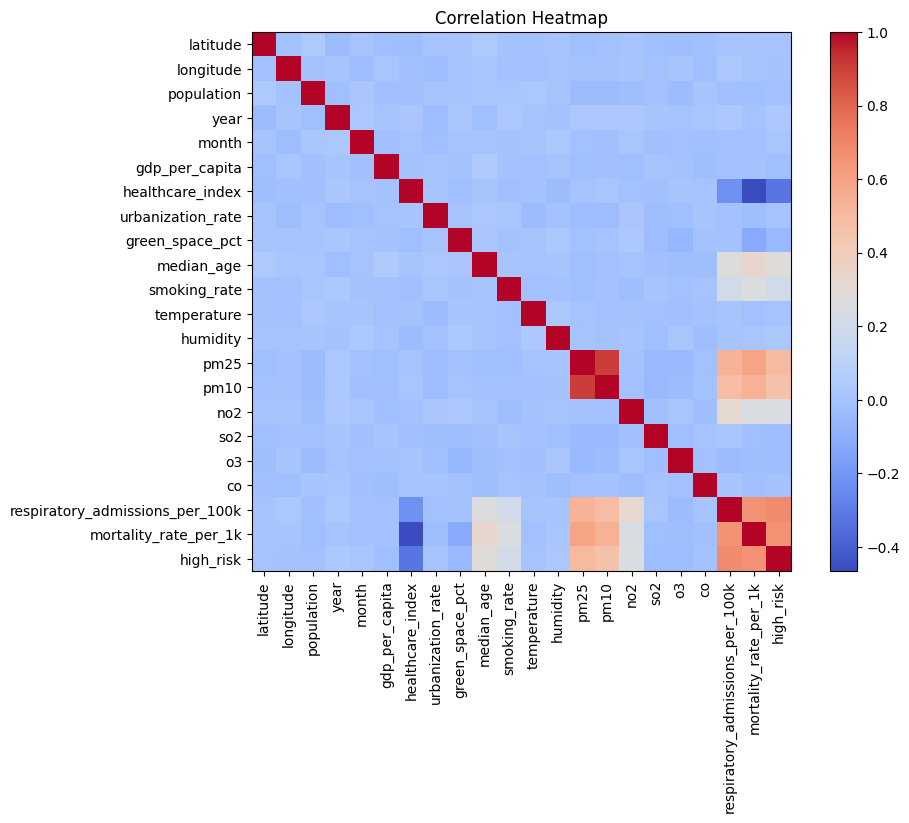


=== Hypothesis Test: High GDP vs Low GDP PM2.5 ===
t-statistic: -0.8910905641076289
p-value: 0.37295209382973715

Using features for regression: ['pm25', 'no2', 'smoking_rate', 'median_age', 'healthcare_index', 'green_space_pct', 'population_k']

=== Regression Results ===
Coefficients: {'pm25': np.float64(0.1368448569341579), 'no2': np.float64(0.0977147257866361), 'smoking_rate': np.float64(0.19415011083623915), 'median_age': np.float64(0.1744478423322245), 'healthcare_index': np.float64(-0.08648572535251131), 'green_space_pct': np.float64(-0.008081441226077932), 'population_k': np.float64(4.824224004676414e-06)}
Intercept: 5.240758299622463
MSE: 13.412788978379972
R^2: 0.5360701895973471


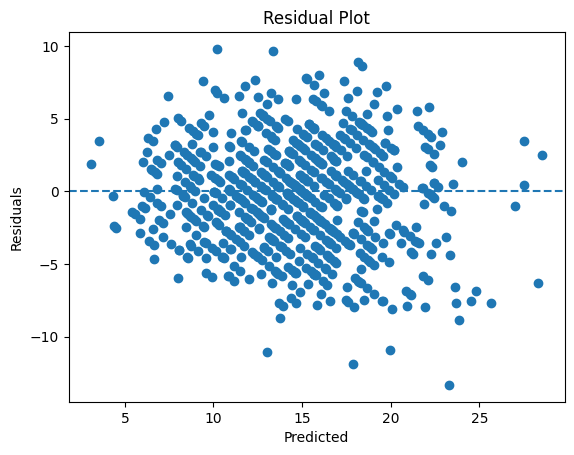


=== Logistic Regression Results ===
Accuracy: 0.9106666666666666
ROC AUC: 0.9663987926806262
Confusion Matrix:
 [[432  33]
 [ 34 251]]


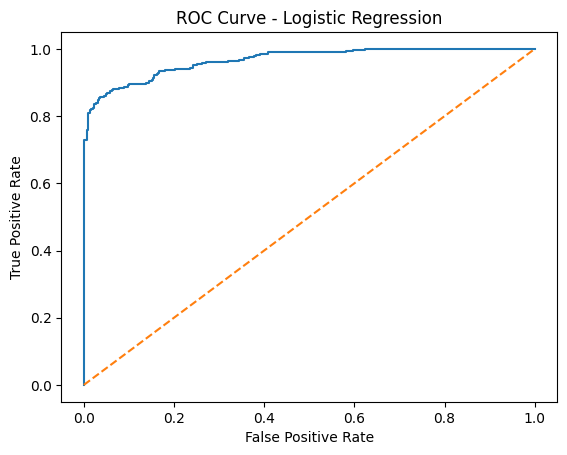


=== LDA Classification ===
LDA Accuracy: 0.9146666666666666

Analysis complete.


In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, roc_auc_score,
    confusion_matrix, roc_curve
)


df = pd.read_csv("/content/global_aq_health (1).csv")
print("Dataset loaded with shape:", df.shape)


print(df.head())



# 2. CLEANING DATA

# Convert to numeric where possible
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="ignore")

# Missing values
print("\nMissing values per column:\n", df.isna().sum())

# Fill numeric missing with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical missing with mode
categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nShape after cleaning:", df.shape)


# 3. EDA + VISUALIZATION

# Histogram: PM2.5
if "pm25" in df.columns:
    plt.hist(df["pm25"], bins=40)
    plt.title("Distribution of PM2.5")
    plt.xlabel("PM2.5 (μg/m³)")
    plt.ylabel("Frequency")
    plt.show()

# Scatter: PM2.5 vs Respiratory Hospitalizations
if "pm25" in df.columns and "respiratory_admissions_per_100k" in df.columns:
    plt.scatter(df["pm25"], df["respiratory_admissions_per_100k"], alpha=0.5)
    plt.title("PM2.5 vs Respiratory Admissions")
    plt.xlabel("PM2.5 (μg/m³)")
    plt.ylabel("Respiratory admissions")
    plt.show()

# Correlation matrix
plt.figure(figsize=(10,7))
plt.imshow(df[numeric_cols].corr(), cmap="coolwarm")
plt.colorbar()
plt.title("Correlation Heatmap")
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.show()


# 4. HYPOTHESIS TESTING
# Example: Does PM2.5 differ between high GDP vs low GDP countries?

if "gdp_per_capita" in df.columns:
    median_gdp = df["gdp_per_capita"].median()

    high_gdp = df[df["gdp_per_capita"] >= median_gdp]["pm25"]
    low_gdp = df[df["gdp_per_capita"] < median_gdp]["pm25"]

    t_stat, p_val = stats.ttest_ind(high_gdp, low_gdp, equal_var=False)

    print("\n=== Hypothesis Test: High GDP vs Low GDP PM2.5 ===")
    print("t-statistic:", t_stat)
    print("p-value:", p_val)
else:
    print("GDP column not found. Skipping t-test.")


# 5. REGRESSION MODEL
target = "respiratory_admissions_per_100k"

candidate_features = [
    "pm25", "no2", "smoking_rate", "median_age",
    "healthcare_index", "green_space_pct", "population"
]

features = [c for c in candidate_features if c in df.columns]

# Convert population to thousands if present
if "population" in features:
    df["population_k"] = df["population"] / 1000
    features.remove("population")
    features.append("population_k")

print("\nUsing features for regression:", features)

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print("\n=== Regression Results ===")
print("Coefficients:", dict(zip(features, reg.coef_)))
print("Intercept:", reg.intercept_)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

# Residual plot
plt.scatter(y_pred, y_test - y_pred)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()



if "high_risk" in df.columns:

    clf_features = [
        f for f in ["pm25", "no2", "smoking_rate",
                    "median_age", "healthcare_index",
                    "green_space_pct"]
        if f in df.columns
    ]

    Xc = df[clf_features]
    yc = df["high_risk"]

    Xc_train, Xc_test, yc_train, yc_test = train_test_split(
        Xc, yc, test_size=0.25, random_state=42, stratify=yc
    )

    # Logistic Regression
    clf = LogisticRegression(max_iter=2000)
    clf.fit(Xc_train, yc_train)

    pred = clf.predict(Xc_test)
    prob = clf.predict_proba(Xc_test)[:, 1]

    print("\n=== Logistic Regression Results ===")
    print("Accuracy:", accuracy_score(yc_test, pred))
    print("ROC AUC:", roc_auc_score(yc_test, prob))
    print("Confusion Matrix:\n", confusion_matrix(yc_test, pred))

    # ROC curve
    fpr, tpr, _ = roc_curve(yc_test, prob)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Logistic Regression")
    plt.show()

    # LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(Xc_train, yc_train)
    lda_pred = lda.predict(Xc_test)

    print("\n=== LDA Classification ===")
    print("LDA Accuracy:", accuracy_score(yc_test, lda_pred))

else:
    print("No 'high_risk' column — skipping classification.")


print("\nAnalysis complete.")